# Assignment 1 - PHYS 7332 Network Science Data 2
## Coding part
_Daniel Uriel González Quezada_

In [1]:
import numpy as np
from numpy.linalg import eig
import networkx as nx
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import pandas as pd

## Problem 3. 

For this question, we will study _eigenvector centrality_. Eigenvector centrality $x_i$ of node $i$ is proportional to the sum of $i$'s neighbors' eigenvector centrality, having thus a tautological definition. Written as an equation, we have
$$x_i = \kappa^{-1} \sum_{i=1}^n A_{ij} x_j,$$
where $\kappa^{-1}$ is an arbitrary constant. Therefore, starting from a uniform non-negative distribution $\textbf{x}(0)$, we can find the eigenvector centrality of the network by iterating
$$\textbf{x}(1) = \textbf{A} \textbf{x}(0)$$
$$\textbf{x}(2) = \textbf{A} \textbf{x}(1)$$
$$\vdots$$
$$\textbf{x}(t) = \textbf{A} \textbf{x}(t-1)$$

It can be shown that $\textbf{x}(t\rightarrow \infty)$ approaches a stable, non-negative distribution, which corresponds to the eigenvector associated to the highest eigenvalue.

### Question a)

In [2]:
def normalize_vector(v):
    return v/np.sqrt(np.sum(v**2))

def eigenvector_centrality(G, u, all_nodes=False, max_iter=10000, tolerance=1E-3):
    g = G.copy()
    A = nx.to_numpy_array(g)
    n = len(g)
    x = normalize_vector(np.ones(n))
    if np.array_equal(A, np.zeros((n,n))):
        return x
    converged = False
    for t in range(max_iter):
        if not t == 0:
            delta_1 = max(np.abs(x - x_t_1))
        else:
            delta_1 = 0
        
        x_t_1 = x.copy()
        x = A @ x # x(t+1) = A x(t)
        if np.array_equal(x, np.zeros(n)):
            print("O_O")
            return x
        x = normalize_vector(x)
        
        delta_2 = max(np.abs(x - x_t_1))
        if delta_1 == delta_2:
            # This is interesting, but sometimes some values of x oscillate between two values, which doesn't allow the algorithm to coverge.
            # In this case, we take the average, which is apparently what the networkx's function does.
            i = np.argmax(x - x_t_1)
            x[i] = (x[i] + x_t_1[i])/2
            x_t_1[i] = (x[i] + x_t_1[i])/2
        
        #print(np.argmax(np.abs(x-x_t_1)))
        #print(x[148], x_t_1[148])
        #print(max(abs(x - x_t_1)))
        if max(np.abs(x - x_t_1)) <= tolerance:
            converged = True
            break
        
    if not converged:
        class ConvergenceError(Exception):
            pass
        raise ConvergenceError("Eigencentrality could not converge to a stable distribution")
    #print(x)
    if all_nodes:
        return x
    return x[list(g.nodes).index(u)]
        
    

In [3]:
G = nx.erdos_renyi_graph(1000, 0.001, seed=123)
#nx.draw(G)
print(eigenvector_centrality(G,148))
print(nx.eigenvector_centrality(G, max_iter=10000)[148])

0.58863745230311
0.5890602489496211


### Question b)

In [4]:
def eigenvector_centrality_evolved(G, u, all_nodes=False, max_iter=10000, tolerance=1E-3):
    if u not in G and u != -1:
        class NodeError(Exception):
            pass
        raise NodeError("Node not found")
    if "networkx" not in str(type(G)):
        class InvalidNetworkObject(Exception):
            pass
        raise InvalidNetworkObject("Object is not a networkx Graph")
    if nx.is_directed(G):
        if not nx.is_strongly_connected(G):
            class NotComputable(Exception):
                pass
            raise NotComputable("Not strongly connected network. Problematic case")
    return eigenvector_centrality(G,u, all_nodes=all_nodes, max_iter=max_iter, tolerance=tolerance)

### Question c)

Cases to try: connected graph, unconnected graph, multiple components, one node, complete graph, chain.

In [5]:
def average_difference(G, node):
    return np.average(np.abs(eigenvector_centrality_evolved(G, node, all_nodes=True) - 
              np.array(list(nx.eigenvector_centrality(G, max_iter=10000).values()))))

In [6]:
G_random_fully_connected  = nx.erdos_renyi_graph(1000, 0.1, seed=123)
#print(nx.number_connected_components(G_random_fully_connected)) #Fully connected
print("Average difference |my_func(G) - nx's_func(G)|", average_difference(G_random_fully_connected, 0))

Average difference |my_func(G) - nx's_func(G)| 2.9529130257740867e-05


In [7]:
G_disconnected = nx.Graph()
G_disconnected.add_nodes_from(tuple(range(1000)))
#len(G_disconnected.edges)
print("Average difference |my_func(G) - nx's_func(G)| = ", average_difference(G_disconnected, 0))
#eigenvector_centrality_evolved(G_disconnected, 0, all_nodes=True)

Average difference |my_func(G) - nx's_func(G)| =  0.0


In [8]:
G_1 = nx.erdos_renyi_graph(1000, 0.1, seed=1234)
G_2 = nx.erdos_renyi_graph(500, 0.1, seed=12345)
G_union = nx.union(G_1, G_2, rename=("G1-", "G2-"))
nx.number_connected_components(G_union)
print("Average difference |my_func(G) - nx's_func(G)| = ", average_difference(G_union, "G1-1"))

Average difference |my_func(G) - nx's_func(G)| =  0.00018266768365718484


In [9]:
G_complete = nx.complete_graph(100)
print("Average difference |my_func(G) - nx's_func(G)| = ", average_difference(G_complete, 0))

Average difference |my_func(G) - nx's_func(G)| =  1.3877787807814457e-17


In [10]:
#Single node graph
s = nx.Graph()
s.add_node(1)
print("Average difference |my_func(G) - nx's_func(G)| = ", average_difference(s, 1))

Average difference |my_func(G) - nx's_func(G)| =  0.0


In [11]:
#Chain
G_chain = nx.Graph()
G_chain.add_edges_from([(i,i+1) for i in range(0,20)])
print("Average difference |my_func(G) - nx's_func(G)| = ", average_difference(G_chain, 0))

Average difference |my_func(G) - nx's_func(G)| =  0.000342154570269945


### Question d)

In [12]:
def function_tester(f, networkx_function, u=-1, max_iter=10000, all_nodes=True):   
    G_random_fully_connected  = nx.erdos_renyi_graph(1000, 0.1, seed=123)
    G_disconnected = nx.Graph(); G_disconnected.add_nodes_from(tuple(range(1000)))
    G_1 = nx.erdos_renyi_graph(1000, 0.1, seed=1234); G_2 = nx.erdos_renyi_graph(500, 0.1, seed=12345)
    G_union = nx.union(G_1, G_2, rename=("G1-", "G2-"))
    G_complete = nx.complete_graph(100)
    s = nx.Graph(); s.add_node(1)
    G_chain = nx.Graph(); G_chain.add_edges_from([(i,i+1) for i in range(0,20)])

    cases = {"Fully connected": G_random_fully_connected, "Disconnected": G_disconnected, "Two component network": G_union, 
             "Complete network":G_complete, "Single node": s, "Chain network":G_chain}

    results = {}
    for case, g in cases.items():
        try:
            function_test_result = f(g, u, max_iter=max_iter, all_nodes=all_nodes)
            base_result = networkx_function(g, max_iter)
            avg_diff = np.average(np.abs(function_test_result - np.array(list(base_result.values()))))
            results[case] = avg_diff
        except Exception as e:
            results[case] = e

    return results

function_tester(eigenvector_centrality_evolved, nx.eigenvector_centrality)

{'Fully connected': 2.9529130257740867e-05,
 'Disconnected': 0.0,
 'Two component network': 0.00018266768365718484,
 'Complete network': 1.3877787807814457e-17,
 'Single node': 0.0,
 'Chain network': 0.000342154570269945}

## Problem 4.

### Question a)

In [13]:
url = 'https://catalog.northeastern.edu'

catalog_res = requests.get(url + "/course-descriptions/")
catalog_html = catalog_res.text


In [14]:
soup = BeautifulSoup(catalog_html)

soup_alpha_div = soup.find('div', id="atozindex")

department_hrefs = []
for ul in soup_alpha_div.find_all('ul'):
    for li in ul.find_all('li'):
        department_hrefs.append(li.a.get('href'))

In [15]:
def course_titles_descriptions_prerequisites(dept_html):
    """
    Given a string of raw html (dept_html) that contains a department's course titles and descriptions,
    return a useful data structure that contains only the titles and descriptions. 
    """

    soup = BeautifulSoup(dept_html)

    #courses_block = soup.find("div", id="sc_sccoursedescs")
    #print(courses_block)

    courses = soup.find_all("div", {"class":"courseblock"})
    #print(courses[0]
    courses_descriptions = {}
    for course in courses:
        full_name = course.find("p", {"class":"courseblocktitle noindent"}).text.replace("\xa0", " ")
        #print(full_name)
        code, title, hours = tuple(full_name.split(".  "))
        description = course.find("p", {"class":"cb_desc"}).text
        requisites_block = course.find("p", {"class":"courseblockextra noindent"})
        if requisites_block is not None:
            type_ = requisites_block.find("strong").text
            if type_.lower().strip() == "prerequisite(s):":
                requisites = requisites_block.find_all("a", {"class":"bubblelink code"})
            else:
                requisites = None
        else:
            requisites = None
        if requisites is not None:
            requisites  = [requisite.text.replace("\xa0", " ") for requisite in requisites]
        courses_descriptions[code] = {"title":title, "description": description, "prerequisites": requisites}

    return courses_descriptions

#dept_res = requests.get("https://catalog.northeastern.edu/course-descriptions/dgtr/")
#dept_html = dept_res.text
#course_titles_descriptions_prerequisites(dept_html)

### Question b)

In [16]:
prerequisite_graph = nx.DiGraph()
dpt_n_of_pre = {} # avg number of rerequisite courses
for department in department_hrefs:
    n_of_pre = 0
    dept_html = requests.get(url + department).text
    courses = course_titles_descriptions_prerequisites(dept_html)
    for course in courses:
        if courses[course]["prerequisites"] is None:
            prerequisite_graph.add_node(course)
        elif type(courses[course]["prerequisites"]) is str:
            n_of_pre += 1
            prerequisite_graph.add_edge(courses[course]["prerequisites"], course)
        else:
            n_of_pre += len(courses[course]["prerequisites"])
            prerequisite_graph.add_edges_from([(prereq, course) for prereq in courses[course]["prerequisites"]])
    #print(prerequisite_graph.edges)
    dpt_n_of_pre[department.split("/")[-2]] = n_of_pre/len(courses) if len(courses) != 0 else 0
#nx.draw(prerequisite_graph)

### Question c)

In [17]:
print(dpt_n_of_pre)
largest_dpt_prereq = max(dpt_n_of_pre, key=dpt_n_of_pre.get)
#print(largest_dpt_prereq, dpt_n_of_pre[largest_dpt_prereq])

{'acct': 0.6129032258064516, 'acc': 0.631578947368421, 'avm': 0.6666666666666666, 'afam': 0.0, 'afcs': 1.0869565217391304, 'afrs': 0.0, 'amsl': 0.5333333333333333, 'aly': 1.7297297297297298, 'anth': 2.8529411764705883, 'ant': 0.0, 'apl': 0.15384615384615385, 'arab': 0.36363636363636365, 'arch': 0.4626865671641791, 'army': 0.0, 'art': 0.07692307692307693, 'artg': 0.6176470588235294, 'artf': 0.08, 'arte': 0.13636363636363635, 'arth': 0.16666666666666666, 'artd': 0.7741935483870968, 'aace': 0.0, 'arts': 0.3333333333333333, 'asns': 0.9230769230769231, 'bnsc': 0.8181818181818182, 'bioc': 1.5454545454545454, 'bioe': 1.1470588235294117, 'binf': 1.565217391304348, 'biol': 0.8571428571428571, 'bio': 1.12, 'biot': 0.3269230769230769, 'btc': 1.5, 'busn': 0.05172413793103448, 'exsc': 0.6470588235294118, 'chme': 0.8241758241758241, 'chem': 1.064, 'chm': 1.0666666666666667, 'chns': 0.38095238095238093, 'cive': 0.8467153284671532, 'ced': 0.4117647058823529, 'comm': 0.4, 'cmn': 0.40540540540540543, 'c

In [18]:
import pandas as pd
df_dept = pd.DataFrame(dpt_n_of_pre, index=['count']).T

In [19]:
df_dept.sort_values(by='count',ascending=False)

,count
anth,2.852941
engl,2.401639
engw,2.200000
spns,2.160000
psyc,2.030612
...,...
cop,0.000000
exed,0.000000
eeam,0.000000
lst,0.000000


### Question d)

In [20]:
# Removing weird prerequisites from the Spanish department
prerequisite_graph.remove_edges_from([("SPNS 2102", "SPNS 2102"), ('SPNS 3101', 'SPNS 3101'), ('SPNS 3102', 'SPNS 3102'), ('SPNS 3603', 'SPNS 3602'),
                                     ('SPNS 2101', 'SPNS 2101'),('SPNS 1101', 'SPNS 1101'),('SPNS 1102', 'SPNS 1102')])
nx.is_directed_acyclic_graph(prerequisite_graph)

True

In [21]:
nx.dag_longest_path(prerequisite_graph)

['BIOL 1107',
 'BIOL 1113',
 'PHSC 2301',
 'PHSC 2303',
 'HSCI 1105',
 'NRSG 2220',
 'NRSG 3323',
 'NRSG 3320',
 'NRSG 3420',
 'NRSG 4502',
 'NRSG 4995']

### Question e)

Answer in Assignment pdf.

## Problem 5

### Question a)
Answer in Assignment pdf.

### Question b)

In [22]:
# We load the network
column_names = ["source", "target", "timestamp"]
df = pd.read_csv("data/rt-pol.csv", names=column_names, header=None)
G = nx.from_pandas_edgelist(df, edge_attr="timestamp")
len(G.edges)

48053

In [23]:
degree_counts = nx.degree_histogram(G)

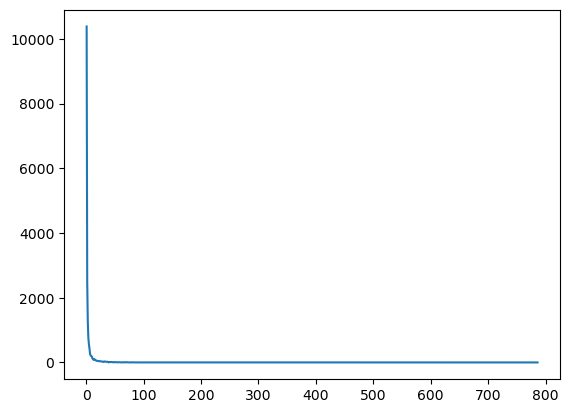

In [24]:
plt.plot(np.arange(1,len(degree_counts), 1), nx.degree_histogram(G)[1:])

In [25]:
def degree_distribution(G, number_of_bins=15, log_binning=True, density=True, directed=False):
    k = list(dict(G.degree()).values()) # get the degree of each node

    # Step 1: We will first need to define the support of our distribution
    kmax = np.max(k)    # get the maximum degree
    kmin = 0            # let's assume kmin must be 0

    # Step 2: Then we'll need to construct bins
    if log_binning:
        bins = np.logspace(0, np.log10(kmax+1), number_of_bins+1)
    else:
        bins = np.linspace(0, kmax+1, num=number_of_bins+1)


    # Step 3: Then we can compute the histogram using numpy
    probs, _ = np.histogram(k, bins, density=density)


    # Step 4: Return not the "bins" but the midpoint between adjacent bin
    #         values. This is a better way to plot the distribution.
    bins_out = bins[1:] - np.diff(bins)/2.0
    
    return bins_out, probs

In [26]:
def local_clustering_distribution(G):
    C_i = nx.clustering(G)
    degree_histogram = np.array(nx.degree_histogram(G))
    degree_histogram = np.where(degree_histogram == 0, np.nan, degree_histogram)
    k_max = len(degree_histogram)
    counts = np.zeros(k_max)
    degrees = np.arange(0, k_max, 1)
    for node, c in C_i.items():
        counts[G.degree(node)] += c
    avg_c = counts/degree_histogram
    #print(avg_c)
    mask = ~np.isnan(avg_c)
    avg_c = avg_c[mask][1:]
    degrees = degrees[mask][1:]
    return degrees, avg_c
#type(local_clustering_distribution(G))

In [27]:
len(np.array(nx.degree_histogram(G)))

787

In [28]:
def eigenvector_centrality_distribution(G):
    b = nx.eigenvector_centrality(G, max_iter=int(1E6))
    degree_histogram = np.array(nx.degree_histogram(G))
    degree_histogram = np.where(degree_histogram == 0, np.nan, degree_histogram)
    k_max = len(degree_histogram)
    counts = np.zeros(k_max)
    degrees = np.arange(0, k_max, 1)
    for node, c in b.items():
        counts[G.degree(node)] += c
    avg_c = counts/degree_histogram
    #print(avg_c)
    mask = ~np.isnan(avg_c)
    avg_c = avg_c[mask][1:]
    degrees = degrees[mask][1:]
    return degrees, avg_c

In [29]:
G_random = G.copy()
G_random = nx.double_edge_swap(G_random, nswap = 0.63*len(G.edges), max_tries= len(G.edges), seed=3141592) 
G_erdos = nx.erdos_renyi_graph(len(G), nx.density(G), seed=2718281828)    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

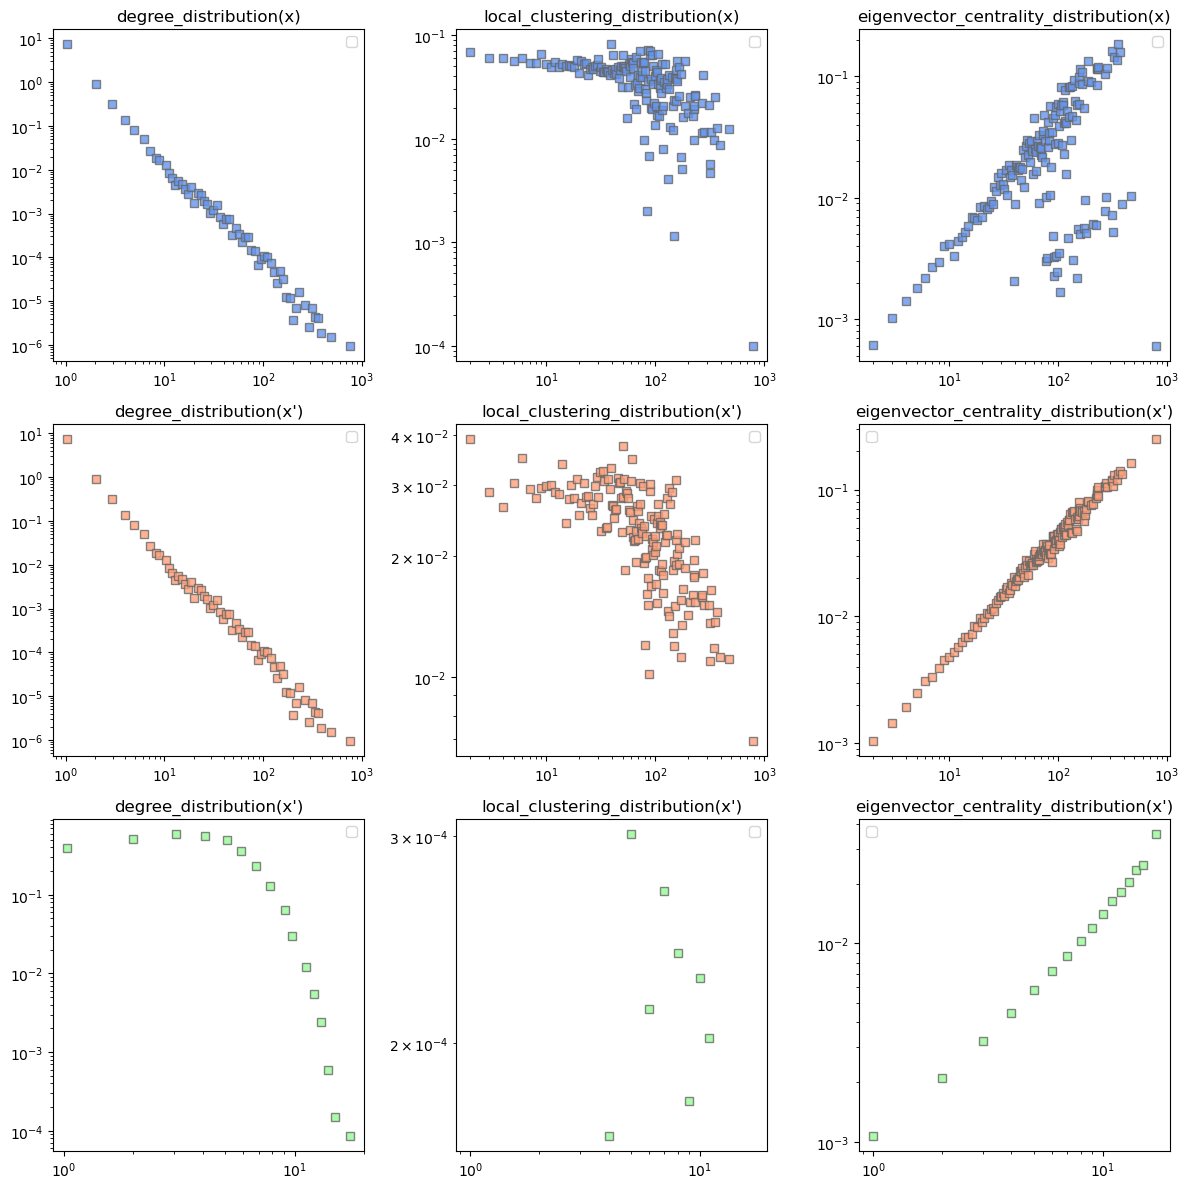

UsageError: Line magic function `%` not found.


In [30]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i, func in enumerate([degree_distribution, local_clustering_distribution, eigenvector_centrality_distribution]):
    if not func == degree_distribution:
        x, y = func(G)
        x_r, y_r = func(G_random)
        x_e, y_e = func(G_erdos)
    else:
        x, y = func(G, number_of_bins=90)
        x_r, y_r = func(G_random, number_of_bins=90)
        x_e, y_e = func(G_erdos, number_of_bins=40)
    axes[0, i].loglog(x, y, 's', color='cornflowerblue', alpha=0.8, mec='.4')
    axes[0, i].set_title(f'{func.__name__}(x)')
    axes[0, i].legend()
    
    axes[1, i].loglog(x_r, y_r, 's', color='lightsalmon', alpha=0.8, mec='.4')
    axes[1, i].set_title(f'{func.__name__}(x\')')
    axes[1, i].legend()

    axes[2, i].loglog(x_e, y_e, 's', color='palegreen', alpha=0.8, mec='.4')
    axes[2, i].set_title(f'{func.__name__}(x\')')
    axes[2, i].legend()
plt.tight_layout()
plt.show()
%

### Question c)
Answer in Assignment pdf.